# Hypothesis Testing: Data Science Salary Comparision in Two Different Regions

## 1. Introduction

**Background Information About Salaries in data science job**

Data science is undoubtedly one of the most lucrative career options, ranking among the top three in terms of compensation. However, it's crucial to recognize that pay can vary significantly based on factors such as location, company, and experience level (Situ et al., 2017). Therefore, it's essential to weigh all aspects before deciding on your career path. Entering the field with unrealistic expectations could lead to disappointment. Geographical location is a crucial factor that can significantly impact your earnings. To highlight the differences in salary across countries, we have provided salary information in USD for selected countries.

**About Our Project**

In this project, we wish to answer the question that:
Is there a difference of the salary of jobs that related to data science in Europe and North America?

More specifically, we will focus on the disparity in data science job salaries between two different regions, Europe and North America. Our response variable is the data science job salary, and we will use the difference in mean salary and standard deviation to evaluate the question. To construct the hypothesis test, we will employ both bootstrapping and asymptotic methods.

**About The Dataset**

Our dataset was found from Kaggle by Ruchi Bhatia, which includes information regarding the data science jobs’ salaries in different locations during the 2020-2022 work year. These data were scraped by Ruchi Bhatia from the source of https://salaries.ai-jobs.net/, which is an AI job searching website. All the variables related to our study along with their corresponding descriptions are included in the table below.

Variables:

1. work_year - The year the salary was paid.
2. location - Regions where employees work (created by us manualy, either Europa or North America)
3. experience_level - The experience level in the job during the year with the following possible values: EN Entry-level / Junior MI Mid-level / Intermediate SE Senior-level / Expert EX Executive-level / Director
4. employment_type - The type of employments for the role: PT Part-time FT Full-time CT Contract FL Freelance
5. job_title - The role worked in during the year.
6. salary_in_usd - The salary in USD (FX rate divided by avg. USD rate for the respective year via fxdata.foorilla.com).
7. company_location - The country of the employer's main office or contracting branch as an ISO 3166 country code.
8. company_size - The average number of people that worked for the company during the year: S less than 50 employees (small) M 50 to 250 employees (medium) L more than 250 employees (large)

## 2. Preliminary Results

### 2.1 Data Cleaning

In [8]:
# load necessary packages
library(infer)
library(tidyverse)
library(cowplot)

In [9]:
raw_salary <- read.csv("https://raw.githubusercontent.com/YuluDuan/Hypothesis-Testing-Data-Science-salary-comparison-in-different-location/main/ds_salaries.csv")

head(raw_salary)

,X,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
,<int>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<chr>
1,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
2,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
3,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
4,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
5,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
6,5,2020,EN,FT,Data Analyst,72000,USD,72000,US,100,US,L


In this project, as we would focus on analyzing the salary in both Europe and North America, it is important to first filter out all the data that belongs to that two countries and select the necessary column (i.e. location and salary_in_usd).

In [10]:
# by checking all the countries in this list, first find out the countries that belongs to Europe and North America.

na <- c("US", "MX","CA")
eur <- c("DE", "GB", "HU", "FR", "GR", "NL", "AT", "ES", "PT", "DK", "IT", "HR", "LU"
         ,"PL", "RO", "BE", "UA", "RU", "MT", "MD", "SI", "CH", "CZ", "EE", "IE")

In [11]:
# fliter out all rows belong to Europe and North America, save them to a new column called "location"

ds_salary <- raw_salary %>%
    filter(company_location %in% append(na, eur)) %>%
    mutate(location = "North America")

ds_salary$location[ds_salary$company_location %in% eur] <- "Europe"

ds_salary$location <- as.factor(ds_salary$location)

In [13]:
# create the final data set for this project by selecting columns that we would be useful.
ds_final <- ds_salary %>%
    select(salary_in_usd, location)
head(ds_final) # overview of the data

,salary_in_usd,location
,<int>,<fct>
1,79833,Europe
2,109024,Europe
3,150000,North America
4,72000,North America
5,190000,North America
6,35735,Europe


Here, we get our final dataset that would be used to data analysis, and we would now provide overview of the data by providing summary and plots. 

### 2.2 Data Summary and Visualization

Firstly, we would provide summary of the salaries, mainly the sample size for each region, and 5-number-summary for them.

* Table 1. Summary of the wages in two different locations

In [57]:
# create the summary of the data by setting a table with information about salary
ds_eur <- ds_final %>%
    filter(location == "Europe")
ds_na <- ds_final %>%
    filter(location == "North America")

summary_eur <- summary(ds_eur$salary_in_usd)
summary_na <- summary(ds_na$salary_in_usd)

location <- c("Europe", "North America")
mini <- c(summary_eur[1], summary_na[1])
quan_1 <- c(summary_eur[2], summary_na[2])
median <- c(summary_eur[3], summary_na[3])
mean <- c(summary_eur[4], summary_na[4])
quan_3 <- c(summary_eur[5], summary_na[5])
max <- c(summary_eur[6], summary_na[6])
sample_size <- summary(ds_final$location)

table1 <- data.frame(minimum_wage = mini, first_quantile = quan_1, 
                     median_wage = median, mean_wage = mean, third_quantile = quan_3, maximum_wage = max, sample_size)
table1

,minimum_wage,first_quantile,median_wage,mean_wage,third_quantile,maximum_wage,sample_size
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Europe,5882,46597.0,63831,69358.37,87932,230000,157
North America,2859,99037.5,130400,139769.85,170000,600000,388


Now we would want to create the histogram of salary for both regions to help us understand the distribution.

* Figure 1: Histograms of Salary in Europe and North America

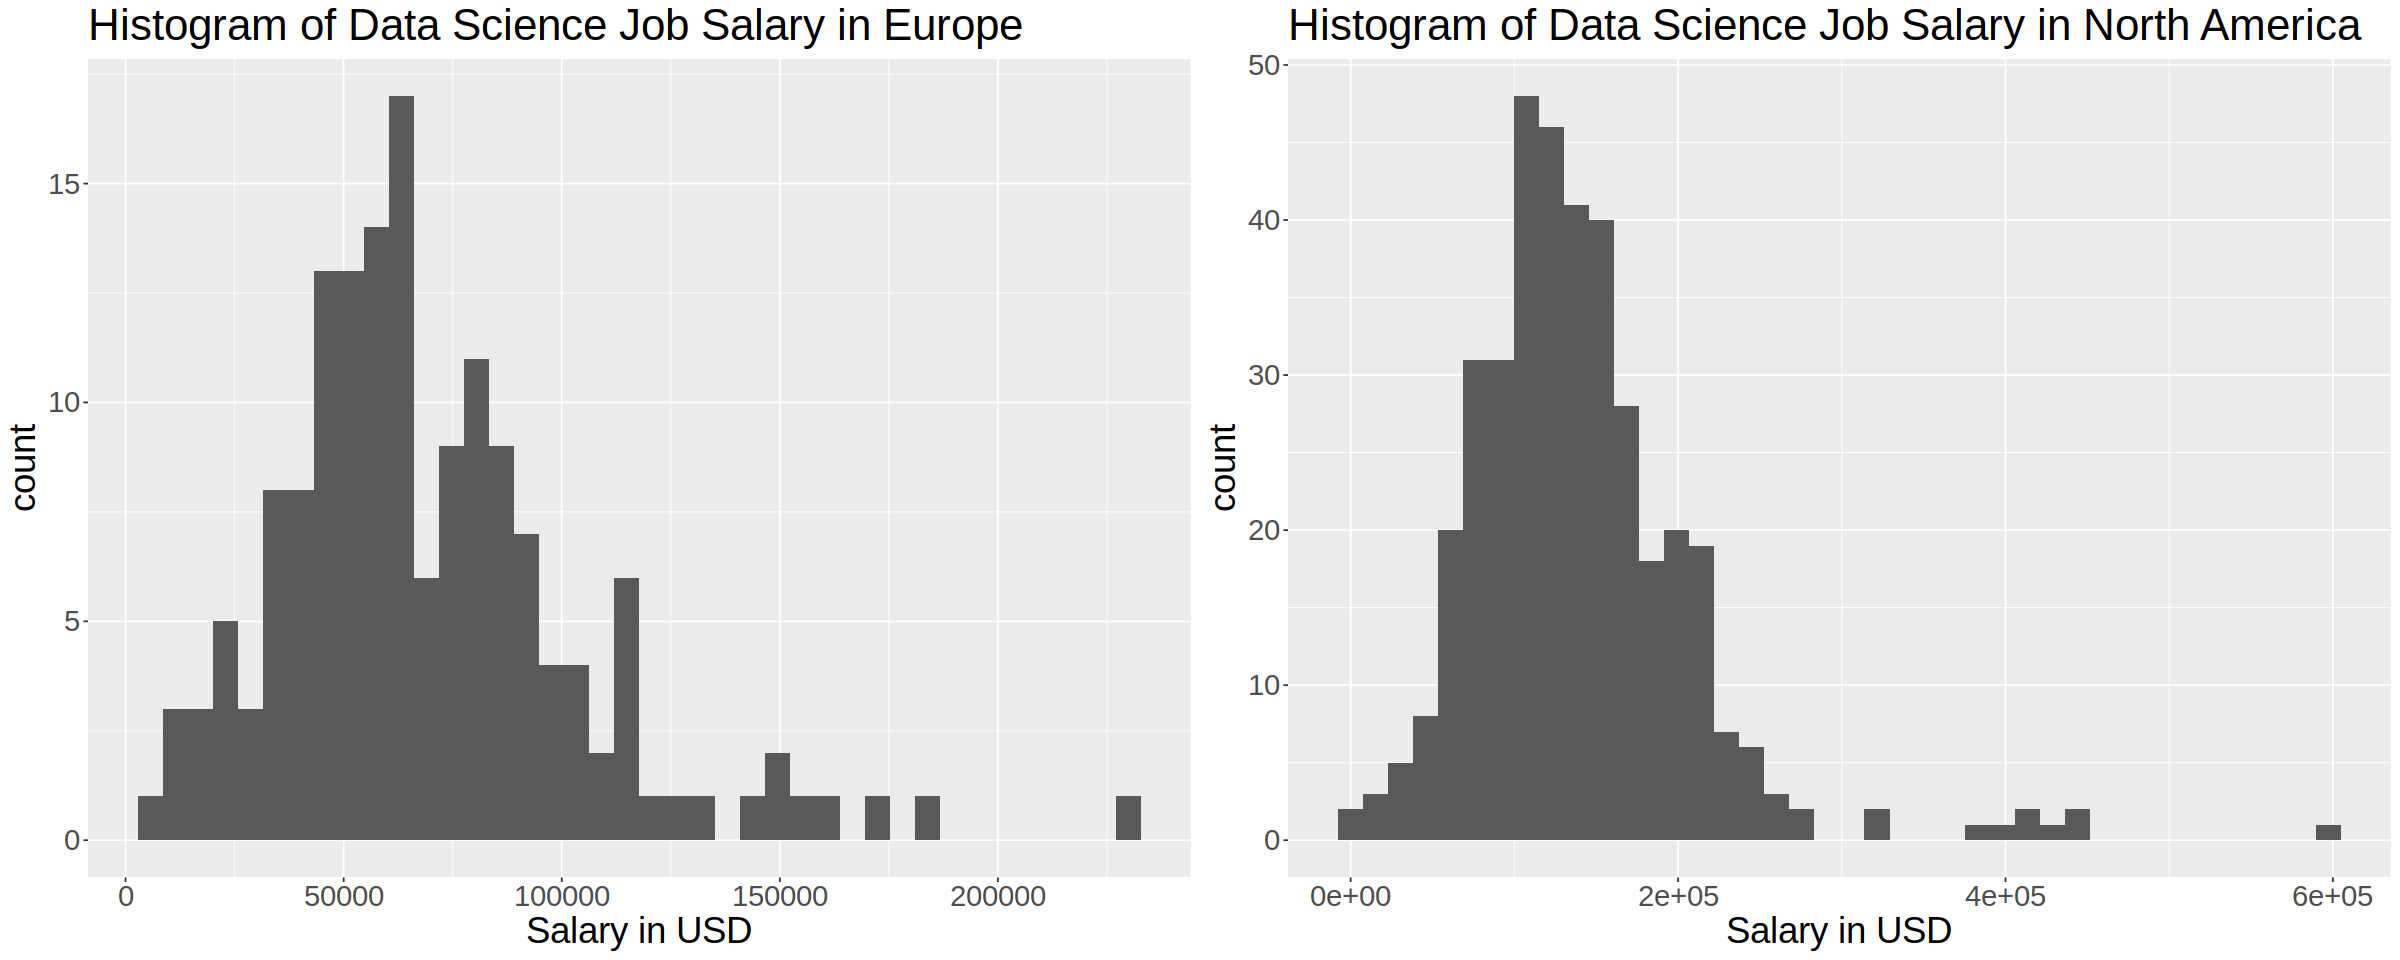

In [67]:
options(repr.plot.width= 20, repr.plot.height=8)
histogram_europe <- ds_final %>%
    filter(location == "Europe") %>%
    ggplot(aes(x = salary_in_usd)) +
    geom_histogram(bins = 40) +
    theme(text = element_text(size = 22)) +
    xlab("Salary in USD") + 
    ggtitle("Histogram of Data Science Job Salary in Europe")
histogram_na <- ds_final %>%
    filter(location == "North America") %>%
    ggplot(aes(x = salary_in_usd),color = 'white') +
    geom_histogram(bins = 40) +
    theme(text = element_text(size = 22)) + 
    xlab("Salary in USD") + 
    ggtitle("Histogram of Data Science Job Salary in North America")

plot_grid(histogram_europe, histogram_na, labels = c('', ''))

For hypothesis testing, solely looking at the 5-number-summary is not enough as there is also variability in our data. Hence, it would be helpful to pay attention to the spread of salaries for each region, which we can compare by side-by-side boxplot.

* Figure 2: Boxplot of the salaries in two different regions

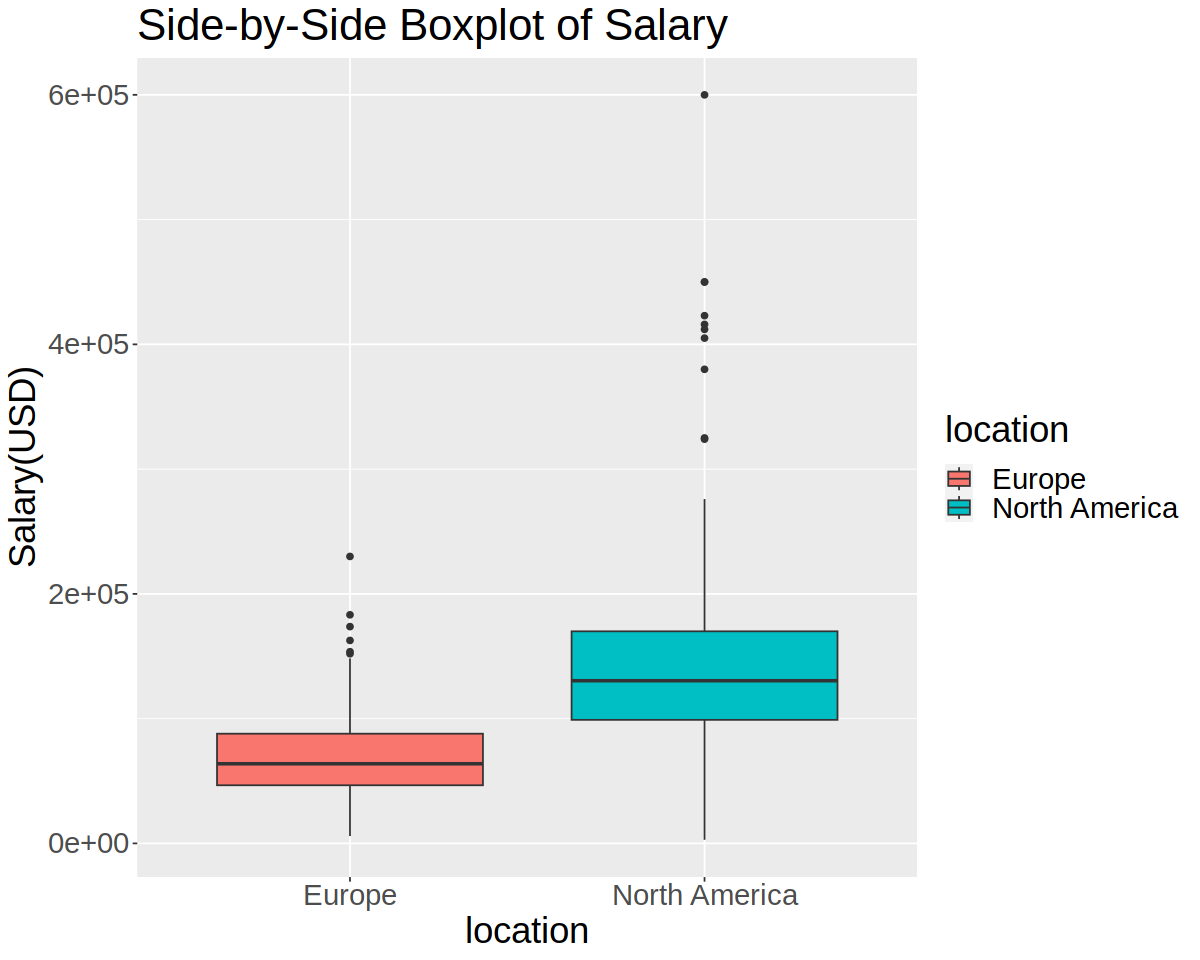

In [11]:
options(repr.plot.width=10, repr.plot.height=8)
boxplot_ds <- ggplot(ds_final, aes(x = location, y = salary_in_usd, fill = location)) +
    geom_boxplot() +
    theme(text = element_text(size = 22)) +
    ylab("Salary(USD)") +
    ggtitle("Side-by-Side Boxplot of Salary")
    
boxplot_ds

## Section 3. Methods: Plan